# Overview

This notebook divides into three parts:

1. Load

2. Plot

3. Data Wrangling

It is to answer the first three questions of a Data Science Challenge. For each part, you can see my codes and visualization. I also documented my thinking process and insights in markdown.

Thank you for taking your time to go through my work.

# Part 1: Load

In [1]:
## Import packages
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns

## Setup display
pd.options.display.max_rows = 999
pd.options.display.max_columns = 50

## Data Collection

In [ ]:
# Data is not currently not available to the public.

In [3]:
!unzip transactions.zip

Archive:  transactions.zip
  inflating: transactions.txt        


## Data Structure
Data is a line-delimited json dataset stored in a text file.
**The dataset has 786363 rows and 29 columns.**

In [4]:
path = 'transactions.txt'
file = pd.read_json(path, lines=True)

print('Data structure:',len(file),'rows and', len(file.columns), 'columns.')

Data structure: 786363 rows and 29 columns.


## Basic Summary Statistics

1. Count null and unique values
2. Identify data types <br>Continuous variables: calculate min, max, mean, standard deviation <br>Categorical variables: number of unique values and distribution

In [5]:
def null_ratio(pd_series):
    return round(pd_series.isna().sum()/len(file)*100,2)

file.replace('', np.nan, inplace = True)
null_and_unique = file.agg([null_ratio, 'nunique']).T
null_and_unique

,null_ratio,nunique
accountNumber,0.00,5000.0
customerId,0.00,5000.0
creditLimit,0.00,10.0
availableMoney,0.00,521915.0
transactionDateTime,0.00,776637.0
transactionAmount,0.00,66038.0
merchantName,0.00,2490.0
acqCountry,0.58,4.0
merchantCountryCode,0.09,4.0
posEntryMode,0.52,5.0


In [6]:
# Remove columns that are 100% null

file.drop(list(null_and_unique[null_and_unique.null_ratio == 100.00].index), axis = 1, inplace = True)

**Continuous variables**

In [7]:
continuous = ['creditLimit','availableMoney', 'currentBalance', 'transactionAmount']
summary_continuous = file[continuous].agg(['min', 'max', 'mean', 'std']).T

summary_continuous

,min,max,mean,std
creditLimit,250.00,50000.00,10759.464459,11636.174890
availableMoney,-1005.63,50000.00,6250.725369,8880.783989
currentBalance,0.00,47498.81,4508.739089,6457.442068
transactionAmount,0.00,2011.54,136.985791,147.725569


Available money have negative values, this could due to overdraft.

**Categorical variables**

In [8]:
categorical = [i for i in list(null_and_unique[null_and_unique['nunique']<100].index) if i in file.columns]
file[categorical].agg(['nunique','unique']).T

,nunique,unique
creditLimit,10,"[5000, 2500, 50000, 15000, 10000, 250, 500, 10..."
acqCountry,4,"[US, nan, CAN, MEX, PR]"
merchantCountryCode,4,"[US, CAN, nan, PR, MEX]"
posEntryMode,5,"[02, 09, 05, 80, 90, nan]"
posConditionCode,3,"[01, 08, 99, nan]"
merchantCategoryCode,19,"[rideshare, entertainment, mobileapps, fastfoo..."
transactionType,3,"[PURCHASE, ADDRESS_VERIFICATION, REVERSAL, nan]"
cardPresent,2,"[False, True]"
expirationDateKeyInMatch,2,"[False, True]"
isFraud,2,"[False, True]"


 Only consider non-null columns that have <= 100 unique values as categorical variables. I will deal with ids and dates variables in feature engineering.

# Part 2: Plot

## Histogram and Observation

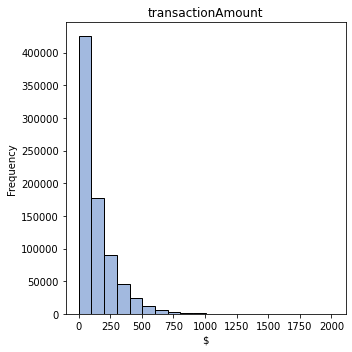

In [9]:
col = 'transactionAmount'  # only need to change this

fig, axes = plt.subplots(1,1, figsize = (5,5))
axes.set_title(col)      
sns.histplot(data=file, x=col, color= '#8ba8d8', bins = 20, alpha=0.8, ax = axes)
axes.set_ylabel('Frequency')
axes.set_xlabel('$')

plt.tight_layout()
plt.show()

**Transaction Amount** is a continuous variable. Data is right-skewed and seems to follow a lognormal distribution, which makes sense as most common transactions are small-amount transactions. I will normalize it during the modeling process.

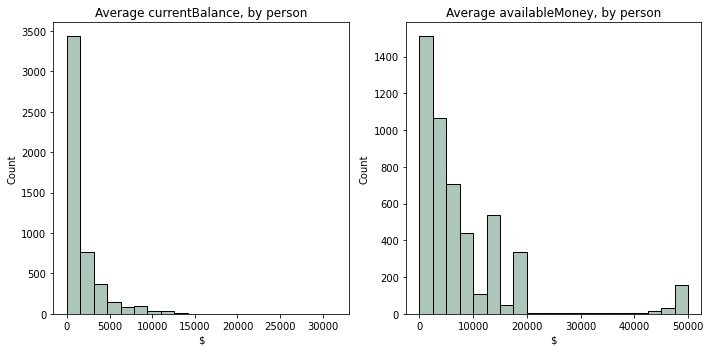

In [10]:
# Histogram of average xxx feature by account

feature_of_interest = ['currentBalance', 'availableMoney']  # only need to change this

fig, axes = plt.subplots(1, 2, figsize = (10, 5))
j = 0

for col in feature_of_interest:
    
    feature_by_person = file[[col, 'accountNumber']].groupby('accountNumber').mean().reset_index()
    sns.histplot(data=feature_by_person, x=col, color = '#76a08b', alpha = 0.6, bins = 20, ax=axes[j])
    axes[j].set_ylabel('Count')
    axes[j].set_title('Average '+col+', by person')
    axes[j].set_xlabel('$')
    j += 1

plt.tight_layout()
plt.show()

For these two variables, I think it makes more sense to see it at a personal level since their 'plain' distribution is affected a lot by different user behaviors.

**Current Balance**: Right skewed. Average is 4.5k, standard deviation from the mean is around 6.5k.

**Available Money**: Right skewed. Average is 6.25k, standard deviation from mean is also high, around 8.9k. There is a spike at 50k range, I think it shows for people with a high credit limit, doesn't usually spend more, or carry a high balance.

All need to be normalized.

Text(0.5, 0, 'Count')

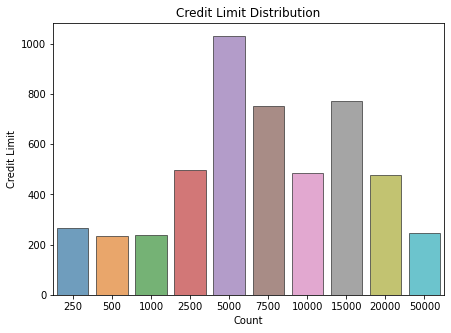

In [11]:
# Distribution of credit limit

col = 'creditLimit'
fig, axes = plt.subplots(1,1, figsize = (7,5))

credit_by_person = file[[col, 'accountNumber']].groupby(col).nunique().reset_index()

sns.barplot(data=credit_by_person, x=col, y='accountNumber', edgecolor=".2", alpha = 0.7, ax=axes)
axes.set_ylabel('Credit Limit')
axes.set_title('Credit Limit Distribution')
axes.set_xlabel('Count')

**Credit Limit**: Credit limit has 10 unique values, it can also be treated as a categorical variable. 5k is the most common credit limit. Average credit limit is 10k. A lot of people have high credit limits. Here I also verify another assumption that each account number only has one credit limit, though he/she can have more than one card.

In [12]:
credit_by_person['accountNumber'].sum() == 5000

True

In [13]:
# Temporarily drop it, will see the distribution later

categorical.remove('merchantCategoryCode') 

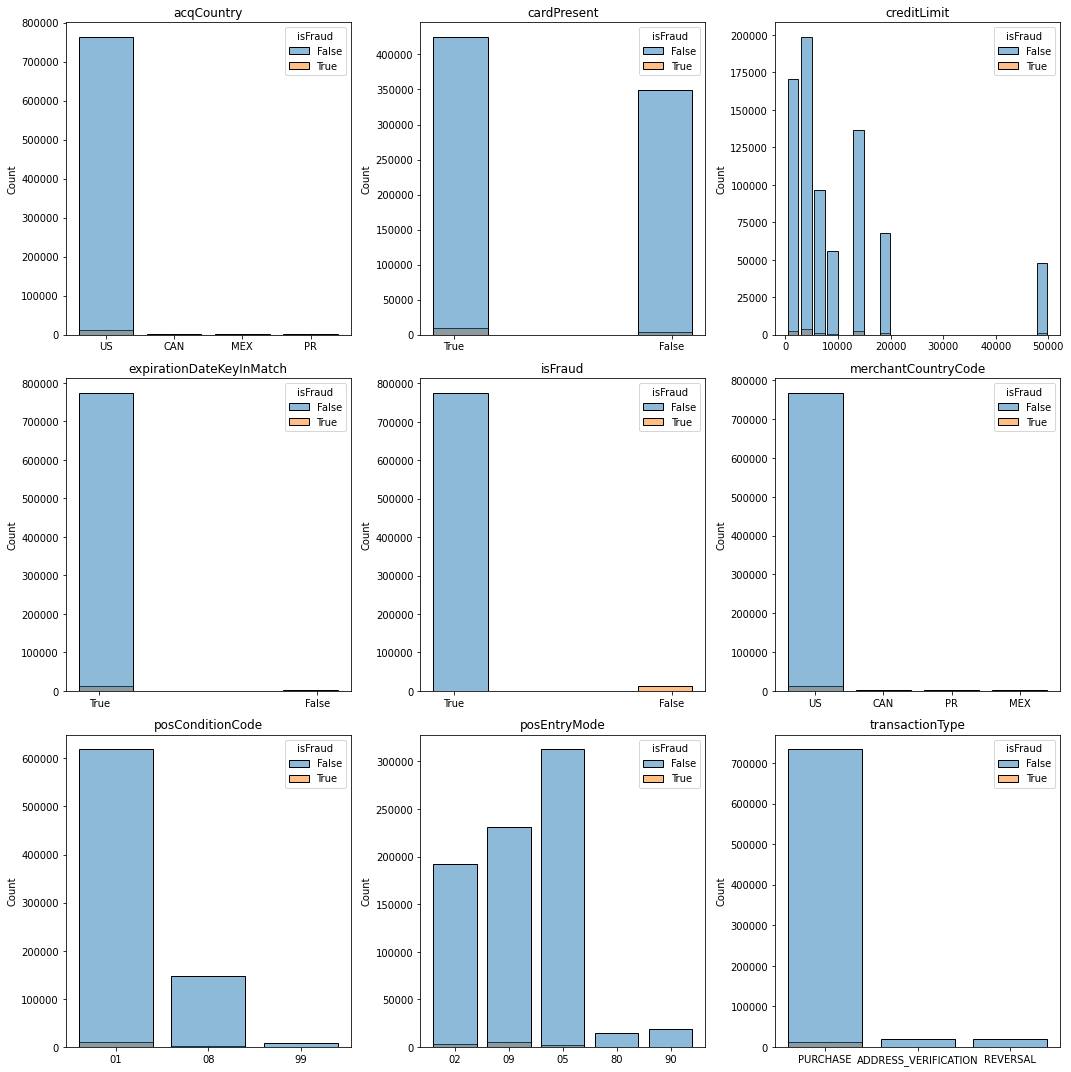

In [14]:
# This script draw histograms for the categorical variables and combine them as a n*3 chart. Previous input are used.

i, j = 0, 0
fig, axes = plt.subplots(round(len(categorical)/3), 3, figsize = (15, 15))

for col in sorted(categorical):

    n_unique = int(null_and_unique.loc[col]['nunique'])
    sns.histplot(data=file, x=col, bins = n_unique*2, hue = 'isFraud',
                 ax = axes[i,j], shrink = 0.8, alpha = 0.5) 
    axes[i,j].set_xlabel('')
    axes[i,j].set_title(col)
    
    if n_unique == 2:  # for binary values
        axes[i,j].set_xticks([0.1,0.9])
        axes[i,j].set_xticklabels(['True', 'False'])
    
    if j == 2: 
        i += 1
        j = 0
    else: 
        j += 1

plt.tight_layout()
plt.show()

## Observation from Categorical Variables

**acqCountry**: Similar to merchantCountryCode, but different distribution. I assume it indicates that most transactions happened in the US.
<br>**cardPresent**: Card-present versus card-not-present is around 55/45, fraudulent events seem to happen more often on card-present transactions.
<br>**creditLimit**: Transactions that happened with lower credit limit accounts tend to have a higher possibility to be a fraud.
<br>**experationDateInMatch**: Highly imbalanced feature, most cases are matched. I will take a look at the 'False' situation in feature engineering, check if they tend to be fraudulent.
<br>**isFraud**: Our target feature. Highly imbalanced. It would impact the feature engineering and model choosing process.
<br>**merchantCountryCode**: As discussed with acqCountry, this feature also shows most transactions happened in the US or were based on the US.
<br>**posConditionCode**: I referred to https://www.mreports.com/documentation/ac/nonmerchant/80449.htm, and find there is no code 99, which might indicate invalid information.
<br>**posEntryMode**: I referred to https://www.mreports.com/documentation/ac/nonmerchant/80451.htm.
<br>**transactionType**: It provides 3 types of transactions: purchase, reversal, and address verification.

Text(0.5, 1.0, 'Transaction Distribution by Merchant Category')

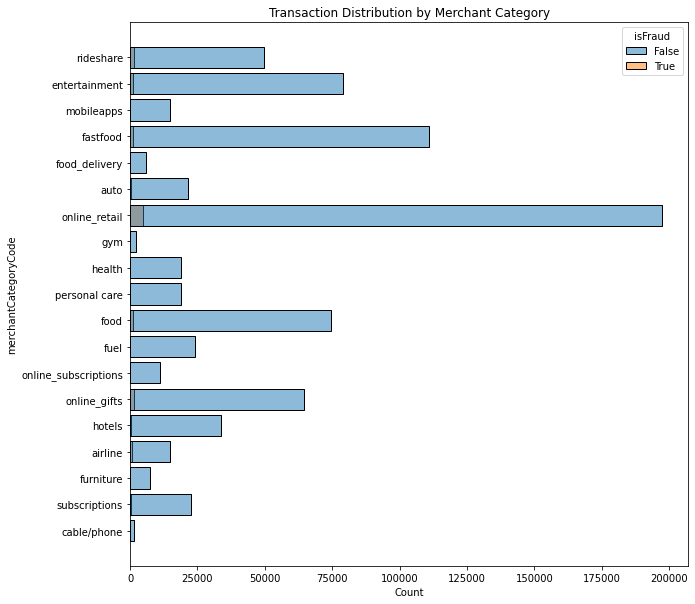

In [15]:
col = 'merchantCategoryCode'

fig, axes = plt.subplots(1,1, figsize = (10,10))
sns.histplot(data=file, y=col, hue = 'isFraud', bins = n_unique*2, #color= '#c5cff0', 
             ax = axes, shrink = 0.8)
axes.set_xlabel('Count')
axes.set_title('Transaction Distribution by Merchant Category')

About 1/4 of transactions are online retail purchases. A lot of frauds also are in this category, which matches with my intuition. This feature has a lot of labels, some categories are very close, for example, food, fast_food and food_delievery. If the final dataset is too sparse I may try to combine some of the categories.

## Summary of Hypotheses and Exploration
1. Column **accountNumber** and **customerId** are identical.

2. Each account is assigned with **one credit limit**, though one account can have **multiple credit cards**.

3. Equation **creditLimit = currentBalance + availableMoney** holds for all transaction records. Need to remove one for multicollinearity-sensitive models.

4. Most **transactionMmount** are less than **moneyAvailable**, I can see that a small amount of overdraft is allowed, which could explain the negative figures in available money.

5. **acqCountry** and **mechantCountryCode** are not always (0.5% of time) the same.

6. Dataset is sorted by **accountNumber** and **transactionDateTime** in ascending order.

In [16]:
# Check accountNumber and customerId are identical

if sum(file.accountNumber == file.customerId) == len(file):
    file.drop('customerId', axis=1, inplace=True)
    print('True')

True


In [17]:
# Check the euqation: creditLimit = currentBalance + availableMoney

sum(file.creditLimit.astype(int) == (file.currentBalance + file.availableMoney).round(0)) == len(file)

True

In [18]:
# Check if transactionAmount is always less than available. (Strength of overdraft protection)

sum(file.transactionAmount < file.availableMoney)/len(file)

0.9617924546297321

In [19]:
# Check if acqCountry and merchantCountryCode are identical

sum(file.acqCountry == file.merchantCountryCode)/len(file)

0.9941095906089172

# Part 3: Data wrangling - duplicate transactions

## Reversed transactions 

They can be identified from transaction type.

In [20]:
reversal = file[file.transactionType == 'REVERSAL'].agg(number_of_transactions = ('transactionAmount','count'), 
                                                        total_dollar_amount = ('transactionAmount','sum')).rename(columns = {'transactionAmount':'reversal'})                               

reversal

,reversal
number_of_transactions,20303.0
total_dollar_amount,2821792.5


In [21]:
# Verify the label: if a transaction can be reversed, it must have an 'orginal' transaction with same accountNumber, merchantName, cardLast4Digits.

len(file[(file[['accountNumber', 'merchantName', 'cardLast4Digits']].duplicated()) & (file.transactionType == 'REVERSAL')]) == 20303

True

## Multi-swipe Transactions

My assumptions:
1. Multi-swipe should happen when using the **same card** with the **same merchant**.
2. The **transaction amount** would be **exactly the same** during multi-swipe since it is an accident.
3. Maximum **time span** between swipes set to **1 hour**.

<AxesSubplot:ylabel='Count'>

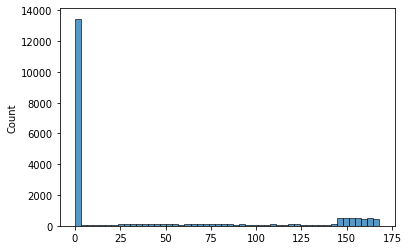

In [22]:
'''
new column - lastTransaction: timedelta since last transaction with specific merchant using the same card.

'''

file['transactionDateTime'] = pd.to_datetime(file.transactionDateTime)
file['lastTransaction'] = file['transactionDateTime'] - \
file.groupby(['accountNumber', 'merchantName', 'transactionAmount', 'cardLast4Digits'])['transactionDateTime'].shift()

sns.histplot([i for i in file.lastTransaction.dt.total_seconds()/3600 if i<168], bins = 50)

From this plot, I determine to use 1 hour as the **time span** to define multi-swipe. For the lower bars at around 150-175 hours, they might be routine charges such as weekly subscriptions.

In [23]:
# Ignored null values in transaction type as they are very rare cases and hard to classify. 

multiple = file[(file[['accountNumber', 'merchantName', 'transactionAmount', 'cardLast4Digits']].duplicated()) & 
                (file.lastTransaction < timedelta(hours=1)) &
                (file.transactionType=='PURCHASE')]

multi_swipe = multiple.agg(number_of_transactions = ('transactionAmount','count'), 
                           total_dollar_amount = ('transactionAmount','sum')).rename(columns = {'transactionAmount':'multi_swipe'})

summary = pd.concat([reversal, multi_swipe], axis = 1)
summary

,reversal,multi_swipe
number_of_transactions,20303.0,7451.00
total_dollar_amount,2821792.5,1103132.25


Estimated number of **reversed transactions** is 20303, total dollar amount is ~2.82 million.<br>Estimated number of **multi-swipe transactions** is 7451, total dollar amount is ~1.1 million.

## My Thoughts
1. I am surprised to see these many multi-swipe transactions happen. 
2. If it can be programmatically identified, maybe we can add a **detection feature** during transactions to ask the customers to **verify** the second/third purchases through mobile app pop-ups, emails, or phone calls. 
3. It may potentially **save costs** in reimbursement and labor in processing the dispute and make a **reliable brand** for our users.

In [24]:
pd.to_pickle(file, 'data.pkl')